<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-паплайна" data-toc-modified-id="Создание-паплайна-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание паплайна</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Проект: Прогнозирование заказов такси

**Описание исследования**:

Компания «Чётенькое такси» предоставляет услуги такси, включая заказы из аэропортов. Для эффективного распределения водителей в периоды пиковой нагрузки необходимо прогнозировать количество заказов на следующий час. В рамках исследования проводится анализ исторических данных, построение и оценка моделей машинного обучения для предсказания спроса на такси.

**Цель исследования:**
Разработать модель, способную предсказывать количество заказов такси на следующий час с точностью не ниже заданного уровня (RMSE ≤ 48 на тестовой выборке).

**Задачи исследования:**

1. Загрузить данные и выполнить ресемплирование по одному часу.
2. Провести исследовательский анализ данных (EDA).
3. Обучить несколько моделей машинного обучения с подбором гиперпараметров.
5. Оценить качество моделей на тестовой выборке и выбрать наилучшую.
6. Сформулировать выводы и рекомендации для компании.

**Импорт библиотек**

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df = df.sort_index()

In [5]:
df.index.is_monotonic

True

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df = df.resample('1H').sum()

*Вывод:* 
1. Данные были загружены и соотвествуют ТЗ.
2. Названия столбцов корректны.
3. Пропусков нет.
4. Выполнено ресемплирование по одному часу.

## Анализ

In [8]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

У нас есть данные с 1 марта 2018 по 31 августа 2018

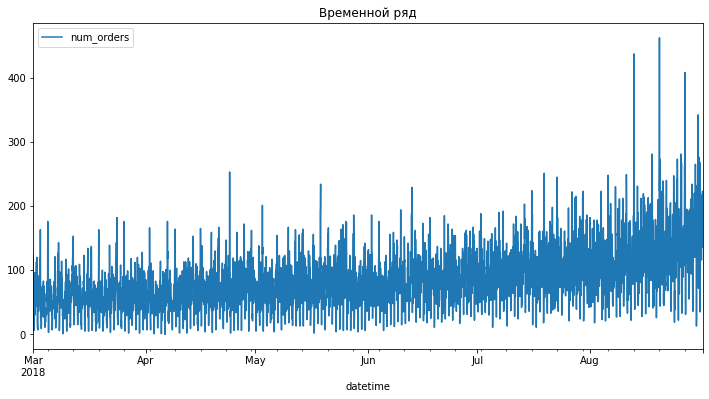

In [9]:
df.plot(figsize = (12, 6))
plt.title('Временной ряд')
plt.show()

По данному графику мало что можно понять

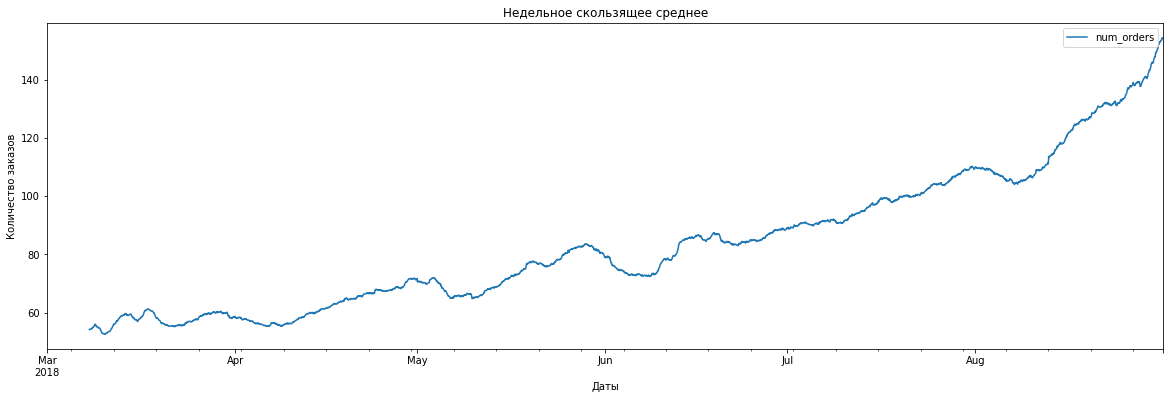

In [10]:
df.rolling(24 * 7).mean().plot(figsize=(20, 6))
plt.title('Недельное скользящее среднее')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.show()

У нас есть плавное увеличение заказов. Проведем анализ сезонности.

In [11]:
decomposed = seasonal_decompose(df, period = 24 * 7)

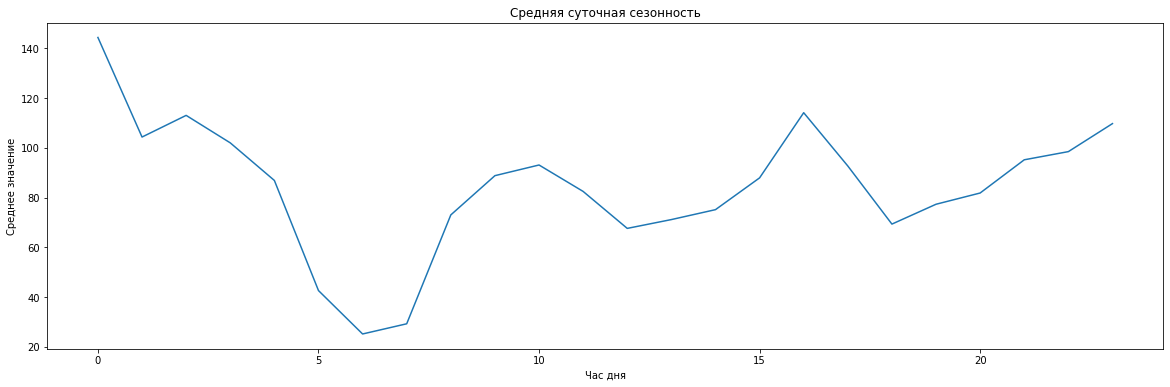

In [12]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

hourly_pattern = df.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(20, 6))
hourly_pattern.plot(title='Средняя суточная сезонность')
plt.xlabel('Час дня')
plt.ylabel('Среднее значение')
plt.show()

Минимальное количество заказов в ~ 6 утра, максимальное - в 00

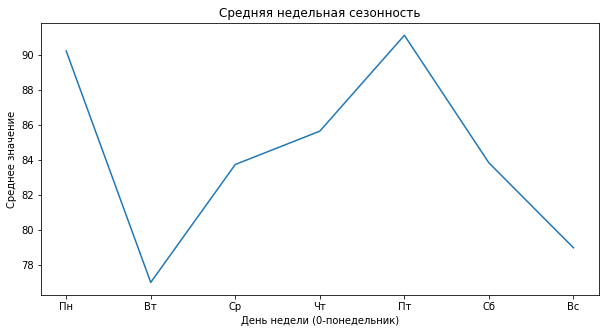

In [13]:
weekday_pattern = df.groupby('dayofweek')['num_orders'].mean()

plt.figure(figsize=(10, 5))
weekday_pattern.plot(title='Средняя недельная сезонность')
plt.xlabel('День недели (0-понедельник)')
plt.ylabel('Среднее значение')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

Больше всего заказов в пт и пн, меньше всего в вт и вс.

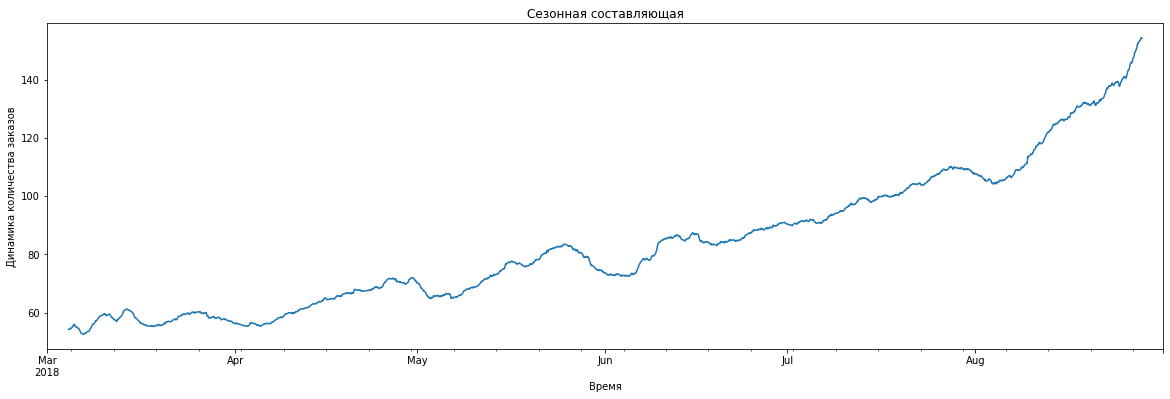

In [14]:
decomposed.trend.plot(figsize=(20, 6))
plt.title('Сезонная составляющая')
plt.xlabel('Время')
plt.ylabel('Динамика количества заказов')
plt.show()

Действительно, количество заказов увеличивается.

In [15]:
df.drop(columns = ['hour', 'dayofweek'], axis = 1, inplace = True)

*Вывод:*

1. Минимальное количество заказов в ~ 6 утра, максимальное - в 00
2. Больше всего заказов в пт и пн, меньше всего в вт и вс.
3. Количество заказов увеличивается

## Подготовка признаков

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


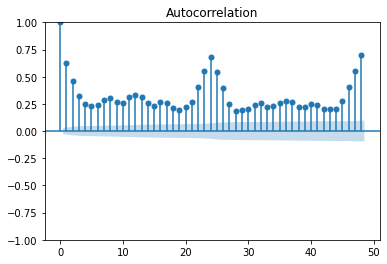

In [17]:
plot_acf(df['num_orders'].dropna(), lags=48, alpha=0.05)
plt.show()

In [18]:
acf_values, confint = acf(df['num_orders'], nlags=48, alpha=0.05, fft=True)

significant_lags = []
for lag in range(1, len(acf_values)):
    if abs(acf_values[lag]) > confint[lag][1] - acf_values[lag]:
        significant_lags.append(lag)

print("Значимые лаги:", significant_lags)

Значимые лаги: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [19]:
def make_features(data, significant_lags):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    
    data['orders_next_hour'] = data['num_orders'].shift(-1)

    for lag in significant_lags:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean_day'] = data['num_orders'].shift().rolling(24).mean()
    data['rolling_mean_week'] = data['num_orders'].shift().rolling(168).mean()

significant_lags = [1, 2, 3, 23, 24, 25] 
make_features(df, significant_lags)

train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
test = test.dropna()

In [20]:
X_train = train.drop('orders_next_hour', axis=1)
y_train = train['orders_next_hour']

X_test = test.drop('orders_next_hour', axis=1)
y_test = test['orders_next_hour']

*Вывод:* Были подготовлены признаки

## Обучение

### Создание паплайна

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3806 entries, 2018-03-08 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_orders         3806 non-null   int64  
 1   hour               3806 non-null   int64  
 2   dayofweek          3806 non-null   int64  
 3   day                3806 non-null   int64  
 4   lag_1              3806 non-null   float64
 5   lag_2              3806 non-null   float64
 6   lag_3              3806 non-null   float64
 7   lag_23             3806 non-null   float64
 8   lag_24             3806 non-null   float64
 9   lag_25             3806 non-null   float64
 10  rolling_mean_day   3806 non-null   float64
 11  rolling_mean_week  3806 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 386.5 KB


In [22]:
num_cols = [
    'num_orders',
    'lag_1',
    'lag_2',
    'lag_3',
    'lag_23',
    'lag_24',
    'lag_25',
    'rolling_mean_day',
    'rolling_mean_week',
]
cat_cols = ['hour','dayofweek', 'day']

In [23]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

### Подбор гиперпараметров

In [24]:
param_distributions = [
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVR()],
        'models__C': [0.1, 1, 10, 100],  
        'models__gamma': ['scale', 'auto'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [lgb.LGBMRegressor()]
    }
]

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(pipe_final, 
                    param_distributions, 
                    cv=tscv,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error'  
)

In [26]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['hour',
                                                                          'dayofweek',...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVR()], 'models__C': [0.1, 1, 10, 100],
                          'models__gamma': ['scale', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LGBMRegressor()]}],
             scoring='neg_root_mean_squared_error')

In [27]:
results = grid.cv_results_
results_df = pd.DataFrame(results)

ranking_columns = ['params', 'mean_test_score', 'rank_test_score']
ranking_df = results_df[ranking_columns].sort_values(by='rank_test_score')

print("Рейтинг моделей:")
display(ranking_df.head(10))

Рейтинг моделей:


,params,mean_test_score,rank_test_score
305,"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}",-26.084808,1
306,"{'models': LinearRegression(), 'preprocessor__num': MinMaxScaler()}",-26.084872,2
307,"{'models': LinearRegression(), 'preprocessor__num': 'passthrough'}",-26.089035,3
303,"{'models': SVR(), 'models__C': 100, 'models__gamma': 'auto', 'preprocessor__num': MinMaxScaler()}",-26.874811,4
308,{'models': LGBMRegressor()},-27.545720,5
302,"{'models': SVR(), 'models__C': 100, 'models__gamma': 'auto', 'preprocessor__num': StandardScaler()}",-27.843097,6
301,"{'models': SVR(), 'models__C': 100, 'models__gamma': 'scale', 'preprocessor__num': 'passthrough'}",-28.879872,7
16,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 9, 'preprocessor__num': StandardScaler()}",-28.887923,8
18,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 10, 'preprocessor__num': StandardScaler()}",-28.923481,9
14,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 8, 'preprocessor__num': StandardScaler()}",-28.927769,10


*Вывод:*

1. Создан паплайн с маштабированием StandardScaler и кодированием OneHotEncoder.
2. Создана метрика RMSE
3. Для каждой модели был проведен подбор гиперпараметров
4. Обучены модели: KNeighborsRegressor, DecisionTreeRegressor, SVR, LinearRegression, LGBMRegressor.
5. Лучшая модель - LinearRegression с **RMSE = 26.08**

## Тестирование

In [28]:
best_model = grid.best_estimator_.steps[1][1]
data_preprocessor.fit(X_train)
X_test_prepared = data_preprocessor.transform(X_test)

In [29]:
X_pred_test = best_model.predict(X_test_prepared)
mean_squared_error(X_pred_test, y_test) ** 0.5

41.65060798904511

Так как критерий успеха - значение метрики RMSE на тестовой выборке <= 48, то считаем нашу модель успешной

## Вывод

**Общий вывод:**

1. Данные были загружены и соотвествуют ТЗ.
2. Названия столбцов корректны.
3. Пропусков нет.
4. Выполнено ресемплирование по одному часу.
5. Минимальное количество заказов в ~ 6 утра, максимальное - в 00.
6. Больше всего заказов в пт и пн, меньше всего в вт и вс.
7. Количество заказов увеличивается.
8. Были подготовлены признаки
9. Создан паплайн с маштабированием StandardScaler и кодированием OneHotEncoder.
10. Создана метрика RMSE
11. Для каждой модели был проведен подбор гиперпараметров
12. Обучены модели: KNeighborsRegressor, DecisionTreeRegressor, SVR, LinearRegression, LGBMRegressor.
13. Лучшая модель - LinearRegression с RMSE = 26.08
14. Значение метрики на тестовой выборке **RMSE = 41.65**